 Todo: Aktualisieren:
<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item">
    <li><span><a href="#|-Preliminaries" data-toc-modified-id="|-Preliminaries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>| Preliminaries</a></span></li><li><span><a href="#|-Cleaning" data-toc-modified-id="|-Cleaning-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>| Cleaning</a></span></li><li><span><a href="#|-Named-Entity-Recognition-w/-spaCy" data-toc-modified-id="|-Named-Entity-Recognition-w/-spaCy-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>| Named Entity Recognition w/ spaCy</a></span><ul class="toc-item"><li><span><a href="#Split-first,-middle-and-last-name-in-different-cols" data-toc-modified-id="Split-first,-middle-and-last-name-in-different-cols-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Split first, middle and last name in different cols</a></span></li><li><span><a href="#|-Enrich-first-name-if-only-last-name-is-mentioned" data-toc-modified-id="|-Enrich-first-name-if-only-last-name-is-mentioned-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>| Enrich first name if only last name is mentioned</a></span></li></ul></li><li><span><a href="#|-Gender-Guesser" data-toc-modified-id="|-Gender-Guesser-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>| Gender Guesser</a></span></li><li><span><a href="#|-Group-per-article-and-get-share-of-gender-per-article" data-toc-modified-id="|-Group-per-article-and-get-share-of-gender-per-article-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>| Group per article and get share of gender per article</a></span></li><li><span><a href="#|-Wikidata-Query" data-toc-modified-id="|-Wikidata-Query-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>| Wikidata Query</a></span></li></ul></div>

---
# | Preliminaries

In [1]:
import os
import json
import pandas as pd
import numpy as np
import regex as re
from pandarallel import pandarallel
import pathlib
import matplotlib.pyplot as plt

#from bs4 import BeautifulSoup as bs

# SpaCy 
import spacy
import en_core_web_trf
import en_core_web_md
import en_core_web_sm

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk

# TRF Orininal / Md schneller
nlp = spacy.load("en_core_web_md")
# JULIA nlp = spacy.load("en_core_web_trf")

from spacy.matcher import PhraseMatcher
from spacy.tokens import Span

import warnings
warnings.filterwarnings('ignore') # (action='once')

import tqdm

In [5]:
pandarallel.initialize(progress_bar=True)
#pandarallel.initialize()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [ ]:
def splitFile(TRECfile, quantity):
    """
    TREC_Washington_Post_collection.v4.jl has 728626 Lines and has 15GB.
    It is to large to read into one Dataframe for the most PCs.
    With this function you can split the big TREC-File into as many
    small files you want.
    
    args: 
    TRECfile = Complete Path + Filename
    quantitiy = How many Small files you want to create
    """
    
    # Splitting the Filename out of the Path
    TRECpath = TRECfile.split('\\')
    TRECpath = TRECfile[:(len(TRECpath[-1])*-1)-1]
    
    # Creating a subfolder 'small' for the new Files
    TRECpathSmall = os.path.join(TRECpath, 'small')
    if not os.path.exists(TRECpathSmall):
        os.makedirs(TRECpathSmall)
        print(f'{TRECpathSmall} wurde erstellt.')
    
    # If the folder 'small' is noot already there and has data skip this function
    TRECfileSmall = os.listdir(TRECpathSmall)
    if not TRECfileSmall:
        smallfiles = []
        lines_per_file = int(729000/quantity)
        
        smallfile = None
        i = 1
        try:
            with open(TRECfile) as bigfile:
                for lineno, line in enumerate(bigfile):
                    if lineno % lines_per_file == 0:
                        if smallfile:
                            smallfile.close()
                        #small_filename = 'TREC_Washington_Post_small_{}.jl'.format(lineno + lines_per_file)
                        small_filename = f'TREC_Washington_Post_small_{i}.jl'
                        small_filename = os.path.join(TRECpathSmall, small_filename)
                        print(f'{small_filename} wird erstellt')
                        smallfiles.append(small_filename)
                        i+=1
                        smallfile = open(small_filename, "w")
                    smallfile.write(line)
                if smallfile:
                    smallfile.close()
            return smallfiles
        except:
            print('TREC_Washington_Post_collection.v4.jl nicht gefunden')
    else:
        # If the folder 'small' is already there and has data create a list of the data
        TRECfileSmall = os.listdir(TRECpathSmall)
        smallfiles = []
        for smallfile in TRECfileSmall:
            smallfile = os.path.join(TRECpathSmall, smallfile)
            smallfiles.append(smallfile)
        return smallfiles

    
# PATH TO YOUR TREC_Washington_Post_collection JSON
myTRECfile = 'C:\\Users\\Felix\\github\\privat\\dis25_abgabe\\data\\wpdata\\data\\TREC_Washington_Post_collection.v4.jl'
WpDataSmall = splitFile(myTRECfile, 30)

WpDataSmall

In [ ]:
def SmallFilesToPickle(listOfSmallFiles):
    fileending = listOfSmallFiles[0]
    fileending = pathlib.Path(fileending).suffix
    fileending = fileending[1:]
    if fileending == 'jl':
        listOfSmallFilesPickle = []
        for filename in listOfSmallFiles:
            df = pd.read_json(filename, lines=True)

            # Drop empty rows
            df.dropna(inplace = True)

            # delete duplicated and unnecessary columns
            if 'contents' in df.columns:
                df = df.drop(columns='contents')
            #if 'article_url' in df.columns:
            #    df = df.drop(columns='article_url')
            if 'type' in df.columns:
                df = df.drop(columns='type')
            if 'source' in df.columns:
                df = df.drop(columns='source')

            filenamemeameOld = filename
            fileNameNew = filename[:-3]+'.pickle'
            os.remove(filenamemeameOld)
            df.to_pickle(fileNameNew)
            listOfSmallFilesPickle.append(fileNameNew)
            del df
        return listOfSmallFilesPickle
    elif fileending == 'pickle':
        return listOfSmallFiles
    else:
        return None

WpDataSmall = SmallFilesToPickle(WpDataSmall)

WpDataSmall

In [ ]:
# ----------------- LÖSCHEN WENN ANDERE FILES GENUTZT WERDEN SOLLEN  -----------

hundredthousandWPpath = 'C:\\Users\\Felix\\github\\privat\\dis25_abgabe\\data\\wpdata\\data\\hundredthousand_wp.pickle'

del WpDataSmall[:]
WpDataSmall.append(hundredthousandWPpath)
WpDataSmall

# -------------------------------------------------------------------------------

In [ ]:
def createDfFromSmallFiles(listOfSmallFiles):
    fileending = listOfSmallFiles[0]
    fileending = pathlib.Path(fileending).suffix
    fileending = fileending[1:]
    if fileending == 'pickle':
        list_of_dataframes = []
        for filename in listOfSmallFiles:
            to_merge_df = pd.read_pickle(filename)
            list_of_dataframes.append(to_merge_df)

        # write all small dataframes in one big dataframe
        df = pd.concat(list_of_dataframes)        

        # delete the small dataframes for more memory
        del to_merge_df
        del list_of_dataframes

        return df

df = createDfFromSmallFiles(WpDataSmall)

# Randomize the rows and reset a new id
#df = df.sample(frac=1).reset_index(drop=True)

# !!! DATENSATZ VERKLEINERT
df = df[:300]

---
# | Pre Processing

In [ ]:
df = pd.read_csv('hundertausend_csv.csv', nrows=100)

In [ ]:
df

In [ ]:
def dateconvert(x):
    try:
        import datetime  
        ts = datetime.datetime.fromtimestamp(x.published_date/1000)
        # year-month-day with hours-minutes-seconds
        #date = ts.strftime('%Y-%m-%d %H:%M:%S')
        # year-month-day without time
        date = ts.strftime('%Y-%m-%d')
        return date
    except:
        return x.published_date

# converts the epochs datetime to a normale datestring
df['published_date'] = df.parallel_apply(dateconvert, axis=1)

In [ ]:
def createText(x):
    try:
        import pandas as pd
        dfcontent = pd.json_normalize(x.content, max_level=1)
        dfcontent = dfcontent[dfcontent.subtype == 'paragraph']
        #dfcontent = dfcontent[dfcontent.mime == 'text/html']
        contentText = ''
        
        for index, row in dfcontent.iterrows():
            contentText += row["content"]
            contentText += ' '
            
            import re
            contentText = contentText.encode('utf-8').decode('ascii','ignore')
            contentText = re.sub('<[^<]+?>', '', contentText)
            contentText = contentText.replace(u'\xa0', u' ')
            contentText = contentText.replace(f'\\n', ' ')
            contentText = contentText.replace(f'\n', f' ')
            contentText = contentText.replace('  ',' ')
            
        return contentText
    except:
        return None

# creates text from the content column by filtering html and json
df['text'] = df.parallel_apply(createText, axis=1)

# if content json is converted in text delete the column
# !!! df = df.drop(columns='content')

---
# | Cleaning

In [ ]:
df.head(5)

In [ ]:
df['title'] = df['title'].replace('', None)
df['title'] = df['title'].replace(' ', None)
df['title'] = df['title'].replace('None', None)
df['title'] = df['title'].replace(np.nan, None)
df['title'] = df.title.replace(r'^\s*$', None, regex=True)

df.dropna(subset=["title"], inplace=True)

def combineText(x):
    try:
        mergedText = f'{x.title} {x.text}'
        return mergedText
    except:
        return None

# write Title and Text in merged_total_text
df['merged_total_text'] = df.parallel_apply(combineText, axis=1)

# | Named Entity Recognition w/ spaCy

In [ ]:
def createEntitys(x):
    import spacy
    import en_core_web_trf

    # TRF Orininal / Md schneller
    nlp = spacy.load("en_core_web_md")
    # JULIA nlp = spacy.load("en_core_web_trf")
    
    totalText = x['merged_total_text']
    try:
        entitys = {}
        for word in nlp(totalText).ents:
            entitys[str(word)] = word.label_
        return entitys
    except:
        return None

df['entitys'] = df.parallel_apply(createEntitys, axis=1)

In [ ]:
#!pip install gender_guesser  
df['author'] = df['author'].replace('', None)
df['author'] = df['author'].replace(' ', None)
df['author'] = df['author'].replace('None', None)
df['author'] = df['author'].replace(np.nan, None)
# df['author'] = df.author.replace(r'^\s*$', None, regex=True)

def authorGender(x):
    try:
        import gender_guesser.detector as gender
        gd = gender.Detector()
        author = x.author
        author = author.split(' ')[0]
        gender = gd.get_gender(author)
        return gender
    except:
        return None

df['author_gender'] = df.parallel_apply(authorGender, axis=1)

In [ ]:
def findCategory(x):
    try:
        articleUrl = x.article_url

        if articleUrl[:5] == 'https':
            category = articleUrl.split('/')[3]
        elif articleUrl[:1] == '/':
            category = articleUrl.split('/')[1]
        else:
            category = 'other'
        return category
    except:
        return None

# find category from article_url
df['category'] = df.parallel_apply(findCategory, axis=1)

In [ ]:
def communion_context(x):
    try:
        file = 'a_communion.txt'
        with open(file, "r") as tf:
            lines = tf.read().split('\n')
        print(lines)
        import re
        counter = 0
        for line in lines:
            count = sum(1 for _ in re.finditer(r'\b%s\b' % re.escape(line), x.title))
            counter += count
        return counter
    except:
        return None

df['communion_context'] = df.parallel_apply(communion_context, axis=1)

In [ ]:
def agency_context(x):
    try:
        file = 'a_agency.txt'
        with open(file, "r") as tf:
            lines = tf.read().split('\n')
        print(lines)
        import re
        counter = 0
        for line in lines:
            count = sum(1 for _ in re.finditer(r'\b%s\b' % re.escape(line), x.title))
            counter += count
        return counter
    except:
        return None

df['agency_context'] = df.parallel_apply(agency_context, axis=1)

In [ ]:
def getTitleLenght(x):
    try:
        return len(x.title)
    except:
        return None

# write length of title
df['len_title'] = df.parallel_apply(getTitleLenght, axis=1)

In [ ]:
def getTitleWordLenght(x):
    try:
        title = x.title
        import spacy
        nlp = spacy.load('en_core_web_sm')
        title = nlp(title)
        tokenizerLength = len(title)
        return tokenizerLength
    except:
        return None

# write number of title words
df['word_title'] = df.parallel_apply(getTitleWordLenght, axis=1)

In [ ]:
def TitleVaderScore(x):
    try:
        from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
        analyzer = SentimentIntensityAnalyzer()
        title = x.title
        vader_score = analyzer.polarity_scores(title)['compound']
        if vader_score >= 0.05 : 
            return("Positive") 
        elif vader_score <= - 0.05 : 
            return("Negative")  
        else : 
            return("Neutral")
    except:
        return None

# find category from article_url
df['compund'] = df.parallel_apply(TitleVaderScore, axis=1)

In [ ]:
# Speichern des aktuellen Stands

aktuellPickle = 'C:\\Users\\Felix\\github\\privat\\dis25_abgabe\\data\\wpdata\\data\\aktuell.pickle'
if os.path.exists(aktuellPickle):
    os.remove(aktuellPickle)
df.to_pickle(aktuellPickle)

In [ ]:
df

# | Named Entity Recognition w/ spaCy NEU

In [5]:
# Laden des aktuellen Stands
aktuellPickle = 'C:\\Users\\alexander.courtpozan\\Documents\\ACO_TH\\washington_post_bias\\aktuell.pickle'
df_ner_full = pd.read_pickle(aktuellPickle)

In [7]:
# write entity in parsed_text 
parsed_text = []
for text, id in tqdm.tqdm(zip(df_ner_full['merged_total_text'], df_ner_full['id']), total=len(df_ner_full)):
    parsed_text.extend([[id, str(entity), entity.label_] for entity in nlp(text).ents])

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [01:04<00:00,  4.68it/s]


In [8]:
# create dfs from entities
df_ner = pd.DataFrame(parsed_text, columns=['id', 'merged_total_text', 'entity_type'])
df_ner.rename(columns={'merged_total_text': 'entity_per'}, inplace=True)

In [9]:
# merge back to initial df
df_ner_full = (pd.merge(df_ner_full, df_ner, on='id')) 

In [10]:
df_ner_full = (df_ner_full.loc[df_ner_full['entity_type'].isin(['PERSON'])])

In [11]:
# Replace artist names (Sting, Bono, Cher etc.) with name according to wikipedia
# TO do: write into dict?
artists = {
            'JFK': 'John Fitzgerald Kennedy',
            'FDR': 'Franklin Delano Roosevelt',
            'Sting': 'Gordon Matthew Sumner',
            'Bono': 'Paul David Hewson',
            'Cher': 'Cherilyn Sarkisian',
            'Madonna': 'Madonna Louise Ciccone',
            'Adele': 'Adele Laurie Adkins',
            'Eminem': 'Marshall Bruce Mathers',
            'Beyonce': 'Beyoncé Knowles-Carter',
            'Blaine Friedlander': 'Blaine P. Friedlander Jr.'
        }
df_ner_full['entity_per'] = df_ner_full['entity_per'].replace(artists)

In [12]:
df_ner_full.head(2)

,id,article_url,title,author,published_date,type,source,content,publish_date,orig-id,...,entitys,author_gender,category,communion_context,agency_context,len_title,word_title,compund,entity_per,entity_type
1,ABM35HDPIII6RP4GUI2RWXWOTE,/opinions/the-hollow-compassion-of-trump-wary-...,Trump’s America goes full Charles Dickens,Dana Milbank,NaN,NaN,NaN,"[{'content': 'Opinions', 'mime': 'text/plain',...",NaN,NaN,...,"{'Trump’s America': 'ORG', 'Charles Dickens Do...",female,opinions,0,0,41,7,Neutral,Charles Dickens Donald Trumps America,PERSON
22,ABM35HDPIII6RP4GUI2RWXWOTE,/opinions/the-hollow-compassion-of-trump-wary-...,Trump’s America goes full Charles Dickens,Dana Milbank,NaN,NaN,NaN,"[{'content': 'Opinions', 'mime': 'text/plain',...",NaN,NaN,...,"{'Trump’s America': 'ORG', 'Charles Dickens Do...",female,opinions,0,0,41,7,Neutral,Greg Walden,PERSON


In [13]:
def split_name(df, var):
    sub_df = df[var].str.split('\\s+', expand=True)
    result = []

    for _, row in sub_df.iterrows():
        info = {'first_name': '', 'middle_name': '', 'last_name': ''}
        n = row.count()

        if n == 0:
            pass
        elif n == 1:
            info['first_name'] = row.iloc[0]
        elif n == 2:
            info['first_name'], info['last_name'] = row.iloc[:2]
        else:
            info['first_name'] = row.iloc[0]
            info['last_name'] = row.iloc[-1]
            info['middle_name'] = ' '.join([(string or '') for string in row.iloc[1:-1]])
        result.append(info)
    return pd.DataFrame(result, index=df.index)

df_names = split_name(df_ner_full, 'entity_per')
df_ner_full = df_ner_full.join(df_names)

In [14]:
#!pip install gender_guesser    
import gender_guesser.detector as gender
gd = gender.Detector()
df_ner_full['gender_guesser'] = df_ner_full['first_name'].apply(str.capitalize).map(lambda x: gd.get_gender(x))

In [15]:
#df.drop(['agency_context', 'len_title', 'word_title', 'compund', 'content', 'communion_context', 'category' , 'entitys'], axis=1, inplace=True)#

In [16]:
df_ner_full.gender_guesser.value_counts()

male             1942
unknown          1554
female            630
mostly_male       129
mostly_female     107
andy               40
Name: gender_guesser, dtype: int64

In [17]:
df_ner_full

,id,article_url,title,author,published_date,type,source,content,publish_date,orig-id,...,agency_context,len_title,word_title,compund,entity_per,entity_type,first_name,middle_name,last_name,gender_guesser
1,ABM35HDPIII6RP4GUI2RWXWOTE,/opinions/the-hollow-compassion-of-trump-wary-...,Trump’s America goes full Charles Dickens,Dana Milbank,NaN,NaN,NaN,"[{'content': 'Opinions', 'mime': 'text/plain',...",NaN,NaN,...,0,41,7,Neutral,Charles Dickens Donald Trumps America,PERSON,Charles,Dickens Donald Trumps America,None,male
22,ABM35HDPIII6RP4GUI2RWXWOTE,/opinions/the-hollow-compassion-of-trump-wary-...,Trump’s America goes full Charles Dickens,Dana Milbank,NaN,NaN,NaN,"[{'content': 'Opinions', 'mime': 'text/plain',...",NaN,NaN,...,0,41,7,Neutral,Greg Walden,PERSON,Greg,,Walden,male
24,ABM35HDPIII6RP4GUI2RWXWOTE,/opinions/the-hollow-compassion-of-trump-wary-...,Trump’s America goes full Charles Dickens,Dana Milbank,NaN,NaN,NaN,"[{'content': 'Opinions', 'mime': 'text/plain',...",NaN,NaN,...,0,41,7,Neutral,Cathy McMorris,PERSON,Cathy,,McMorris,female
25,ABM35HDPIII6RP4GUI2RWXWOTE,/opinions/the-hollow-compassion-of-trump-wary-...,Trump’s America goes full Charles Dickens,Dana Milbank,NaN,NaN,NaN,"[{'content': 'Opinions', 'mime': 'text/plain',...",NaN,NaN,...,0,41,7,Neutral,Kristin,PERSON,Kristin,,,female
26,ABM35HDPIII6RP4GUI2RWXWOTE,/opinions/the-hollow-compassion-of-trump-wary-...,Trump’s America goes full Charles Dickens,Dana Milbank,NaN,NaN,NaN,"[{'content': 'Opinions', 'mime': 'text/plain',...",NaN,NaN,...,0,41,7,Neutral,Erik Paulsen,PERSON,Erik,,Paulsen,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18870,71954c18-e1c8-11e3-9743-bb9b59cde7b9,https://www.washingtonpost.com/lifestyle/style...,Alejandro Jodorowsky’s ‘Dance of Reality’ take...,Steve Dollar,2014-05-23,article,The Washington Post,"[{'content': 'Style', 'mime': 'text/plain', 't...",NaN,NaN,...,1,88,17,Negative,Jodorowskys Dune,PERSON,Jodorowskys,,Dune,unknown
18871,71954c18-e1c8-11e3-9743-bb9b59cde7b9,https://www.washingtonpost.com/lifestyle/style...,Alejandro Jodorowsky’s ‘Dance of Reality’ take...,Steve Dollar,2014-05-23,article,The Washington Post,"[{'content': 'Style', 'mime': 'text/plain', 't...",NaN,NaN,...,1,88,17,Negative,Frank Herberts,PERSON,Frank,,Herberts,male
18872,71954c18-e1c8-11e3-9743-bb9b59cde7b9,https://www.washingtonpost.com/lifestyle/style...,Alejandro Jodorowsky’s ‘Dance of Reality’ take...,Steve Dollar,2014-05-23,article,The Washington Post,"[{'content': 'Style', 'mime': 'text/plain', 't...",NaN,NaN,...,1,88,17,Negative,Jodorowsky,PERSON,Jodorowsky,,,unknown
18876,71954c18-e1c8-11e3-9743-bb9b59cde7b9,https://www.washingtonpost.com/lifestyle/style...,Alejandro Jodorowsky’s ‘Dance of Reality’ take...,Steve Dollar,2014-05-23,article,The Washington Post,"[{'content': 'Style', 'mime': 'text/plain', 't...",NaN,NaN,...,1,88,17,Negative,Sarah,PERSON,Sarah,,,female


# | Auswertung

In [18]:
# Laden des aktuellen Stands
aktuellPickle = 'C:\\Users\\alexander.courtpozan\\Documents\\ACO_TH\\washington_post_bias\\aktuell.pickle'
df = pd.read_pickle(aktuellPickle)

In [19]:
df.groupby("author_gender")["id"].count()

author_gender
andy               1
female           105
male             149
mostly_female      6
mostly_male        5
unknown           14
Name: id, dtype: int64

In [20]:
# Es wurden nur 280 AutorInnen ein Gender zugewiesen
df["author_gender"].count()

280

In [21]:
# Insgesamt besteht der Datensatz aktuell aus 300 Zeilen
df["id"].count()

300

In [22]:
gender = ["andy", "female", "male", "mostly_female", "mostly_male", "unknown"]
other = ["andy", "mostly_female", "mostly_male", "unknown"]

In [23]:
# Artikel denen Gender "None" zugeordnet wurde
df[~df.author_gender.isin(gender)]["id"].count()

20

In [24]:
# None Werte aus Spalte 'author_gender' durch 'unknown' ersetzen
df['author_gender'] = df['author_gender'].replace({None: 'unknown'})

In [25]:
# Anzahl Artikel gesamt
'Im Datensatz sind ingesamt ' + str(df["id"].count()) + ' Artikel vorhanden'

'Im Datensatz sind ingesamt 300 Artikel vorhanden'

In [26]:
# Anzahl AutorenInnen
'Die ' + str(df["id"].count()) + ' Artikel wurden von insgesamt ' + str(df["author"].nunique()) + ' AutorInnen verfasst'

'Die 300 Artikel wurden von insgesamt 220 AutorInnen verfasst'

In [27]:
# Anzahl AutorenInnen nach Gender
df.groupby('author_gender')["id"].count().sort_values(ascending=False)

author_gender
male             149
female           105
unknown           34
mostly_female      6
mostly_male        5
andy               1
Name: id, dtype: int64

Text(0, 0.5, 'Anzahl Artikel')

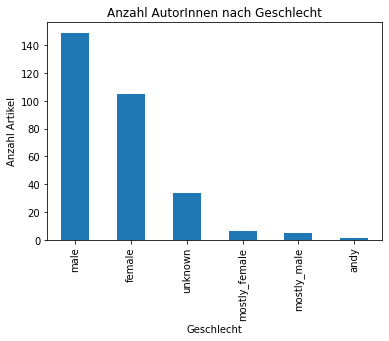

In [28]:
df.groupby('author_gender')["id"].count().sort_values(ascending=False).plot(kind='bar')
plt.title('Anzahl AutorInnen nach Geschlecht')
plt.xlabel('Geschlecht')
plt.ylabel('Anzahl Artikel')

In [29]:
'Die Grafik zeigt, dass ' \
+ str(df[df["author_gender"] == 'male']["id"].count()) + ' Artikel von Männern, ' \
+ str(df[df["author_gender"] == 'female']["id"].count()) + ' von Frauen und ' \
+ str(df[df["author_gender"].isin(other)]["id"].count()) + ' vom Gender Guesser nicht klar zuordenbaren Geschlechtern verfasst worden sind.'

'Die Grafik zeigt, dass 149 Artikel von Männern, 105 von Frauen und 46 vom Gender Guesser nicht klar zuordenbaren Geschlechtern verfasst worden sind.'

In [30]:
# Anzahl Artikel pro AutorIn nach Gender
'Männliche Autoren verfassen bei der Washington Post im Durchschnitt ' + str(round(df[df["author_gender"] == 'male'].groupby("author")["id"].count().mean(), 2)) + ' Artikel, ' \
+ 'Frauen hingegen im Durschnitt ' + str(round(df[df["author_gender"] == 'female'].groupby("author")["id"].count().mean(), 2)) + ' Artikel'

'Männliche Autoren verfassen bei der Washington Post im Durchschnitt 1.31 Artikel, Frauen hingegen im Durschnitt 1.28 Artikel'

(10.0, 80.0)

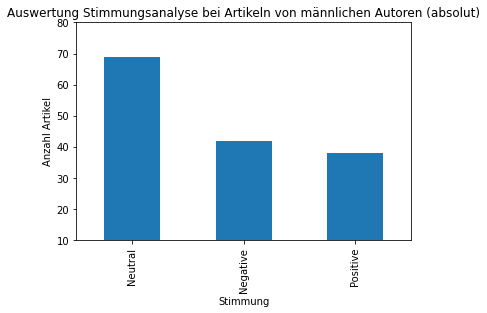

In [31]:
# Vader Stimmungsanalyse Auswertung (absolut) - Männliche Autoren
df[df["author_gender"] == 'male'].groupby(['compund'])["compund"].count().sort_values(ascending=False).plot(kind='bar')
plt.title('Auswertung Stimmungsanalyse bei Artikeln von männlichen Autoren (absolut)')
plt.xlabel('Stimmung')
plt.ylabel('Anzahl Artikel')
plt.ylim([10, 80])

Text(0, 0.5, '')

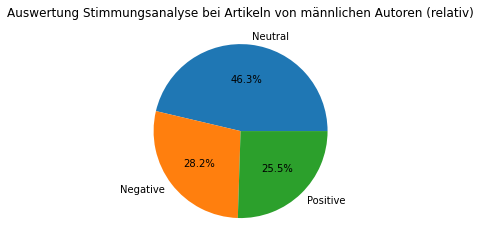

In [32]:
# Vader Stimmungsanalyse Auswertung (relativ) - Männliche Autoren
vader_male = pd.DataFrame(df[df["author_gender"] == 'male'].groupby(['compund'])["id"].count().sort_values(ascending=False))
vader_male["total"] = df[df["author_gender"] == 'male']["id"].count()
vader_male["relative"] = vader_male["id"] / vader_male["total"] * 100
vader_male["relative"].sort_values(ascending=False).plot(kind='pie', autopct='%1.1f%%')
plt.title('Auswertung Stimmungsanalyse bei Artikeln von männlichen Autoren (relativ)')
plt.xlabel("")
plt.ylabel("")

(10.0, 80.0)

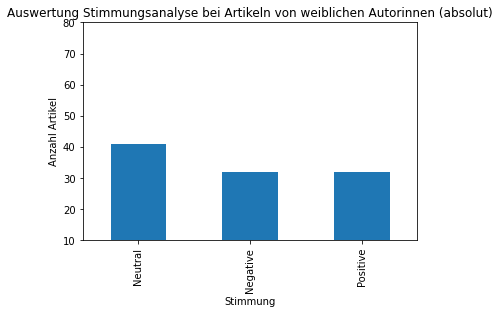

In [33]:
# Vader Stimmungsanalyse Auswertung (absolut) - Weibliche Autorinnen
df[df["author_gender"] == 'female'].groupby(['compund'])["compund"].count().sort_values(ascending=False).plot(kind='bar')
plt.title('Auswertung Stimmungsanalyse bei Artikeln von weiblichen Autorinnen (absolut)')
plt.xlabel('Stimmung')
plt.ylabel('Anzahl Artikel')
plt.ylim([10, 80])

Text(0, 0.5, '')

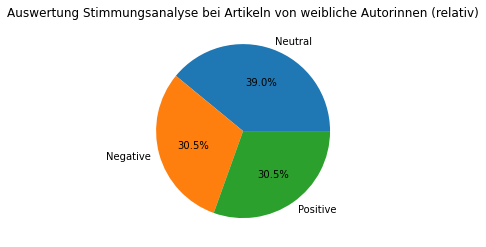

In [34]:
# Vader Stimmungsanalyse Auswertung (relativ) - Weibliche Autorinnen
vader_female = pd.DataFrame(df[df["author_gender"] == 'female'].groupby(['compund'])["id"].count().sort_values(ascending=False))
vader_female["total"] = df[df["author_gender"] == 'female']["id"].count()
vader_female["relative"] = vader_female["id"] / vader_female["total"] * 100
vader_female["relative"].sort_values(ascending=False).plot(kind='pie', autopct='%1.1f%%')
plt.title('Auswertung Stimmungsanalyse bei Artikeln von weibliche Autorinnen (relativ)')
plt.xlabel("")
plt.ylabel("")

In [35]:
# Vader Stimmungsanalyse Auswertung (relativ) - AutorInnen im Vergleich (Datentabelle)
vader_male = vader_male.rename(columns={"id": "vader_male_count", "total": "vader_male_total", "relative": "vader_male_relative"})
vader_female = vader_female.rename(columns={"id": "vader_female_count", "total": "vader_female_total", "relative": "vader_female_relative"})
vader_total = pd.concat([vader_male,vader_female], axis = 1, sort = False)
vader_total

,vader_male_count,vader_male_total,vader_male_relative,vader_female_count,vader_female_total,vader_female_relative
compund,,,,,,
Neutral,69,149,46.308725,41,105,39.047619
Negative,42,149,28.187919,32,105,30.476190
Positive,38,149,25.503356,32,105,30.476190


Text(0, 0.5, 'Anteil Artikel (in%)')

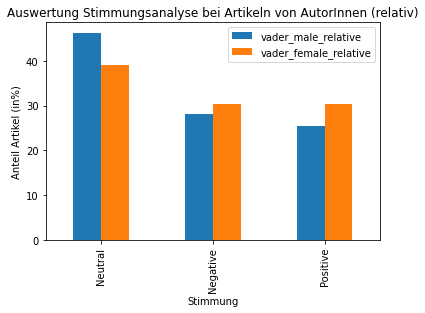

In [36]:
# Vader Stimmungsanalyse Auswertung (relativ) - AutorInnen im Vergleich (Plot)
vader_total[["vader_male_relative", "vader_female_relative"]].plot(kind='bar')
plt.title('Auswertung Stimmungsanalyse bei Artikeln von AutorInnen (relativ)')
plt.xlabel('Stimmung')
plt.ylabel('Anteil Artikel (in%)')

Text(0, 0.5, 'Anzahl Artikel')

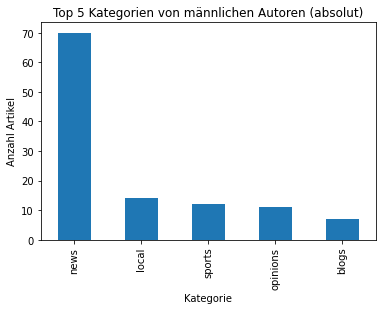

In [37]:
# Top 5 Kateogorien (absolut) - Männliche Autoren
df[df.author_gender == 'male'].groupby(['category'])["id"].count().sort_values(ascending=False).head(5).plot(kind='bar')
plt.title('Top 5 Kategorien von männlichen Autoren (absolut)')
plt.xlabel('Kategorie')
plt.ylabel('Anzahl Artikel')

Text(0, 0.5, '')

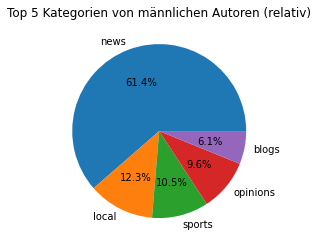

In [38]:
# Top 5 Kateogorien (relativ) - Männliche Autoren
top_male = pd.DataFrame(df[df.author_gender == 'male'].groupby(['category'])["id"].count().sort_values(ascending=False).head(5))
top_male["total"] = df[df["author_gender"] == 'male']["id"].count()
top_male["relative"] = top_male["id"] / top_male["total"] * 100
top_male["relative"].sort_values(ascending=False).plot(kind='pie', autopct='%1.1f%%')
plt.title('Top 5 Kategorien von männlichen Autoren (relativ)')
plt.xlabel("")
plt.ylabel("")

# Info: Prozentualer Anteil auf Basis der Top 5 Kategorien

Text(0, 0.5, 'Anzahl Artikel')

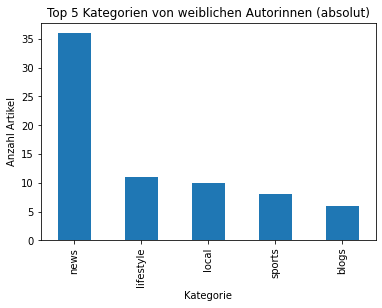

In [39]:
# Top 5 Kateogorien - Weibliche Autorinnen
df[df.author_gender == 'female'].groupby(['category'])["id"].count().sort_values(ascending=False).head(5).plot(kind='bar')
plt.title('Top 5 Kategorien von weiblichen Autorinnen (absolut)')
plt.xlabel('Kategorie')
plt.ylabel('Anzahl Artikel')

Text(0, 0.5, '')

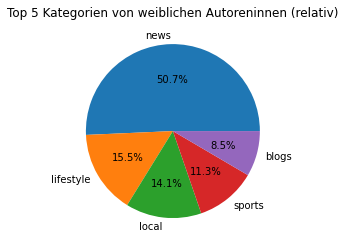

In [40]:
# Top 5 Kateogorien (relativ) - Weibliche Autoreninnen
top_female = pd.DataFrame(df[df.author_gender == 'female'].groupby(['category'])["id"].count().sort_values(ascending=False).head(5))
top_female["total"] = df[df["author_gender"] == 'female']["id"].count()
top_female["relative"] = top_female["id"] / top_female["total"] * 100
top_female["relative"].sort_values(ascending=False).plot(kind='pie', autopct='%1.1f%%')
plt.title('Top 5 Kategorien von weiblichen Autoreninnen (relativ)')
plt.xlabel("")
plt.ylabel("")

# Info: Prozentualer Anteil auf Basis der Top 5 Kategorien

In [41]:
# Auswertung Länge der Artikel/Texte und Speicherung unter neuer Spalte 'len_text'
df["len_text"] = df.apply(lambda row: len(str(row["text"])), axis=1)

Text(0, 0.5, 'Durschnittliche Anzahl Wörter')

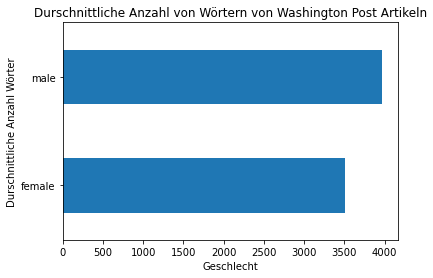

In [42]:
# Durchschnittliche Wörter nach Geschlecht
df[~df.author_gender.isin(other)].groupby(['author_gender'])["len_text"].mean().plot(kind='barh')
plt.title('Durschnittliche Anzahl von Wörtern von Washington Post Artikeln')
plt.xlabel('Geschlecht')
plt.ylabel('Durschnittliche Anzahl Wörter')

In [43]:
'Die Grafik zeigt, dass' \
+ ' männliche Autoren im Durchschnitt ' +  str(round(df[df["author_gender"] == 'male']["len_text"].mean(),2)) + ' Wörter verfassen' \
+ ' und weibliche Autorinnen im Durchschnitt ' +  str(round(df[df["author_gender"] == 'female']["len_text"].mean(),2)) + ' Wörter verfassen '

'Die Grafik zeigt, dass männliche Autoren im Durchschnitt 3962.64 Wörter verfassen und weibliche Autorinnen im Durchschnitt 3510.12 Wörter verfassen '

### Gender Guesser

<AxesSubplot:xlabel='gender_guesser'>

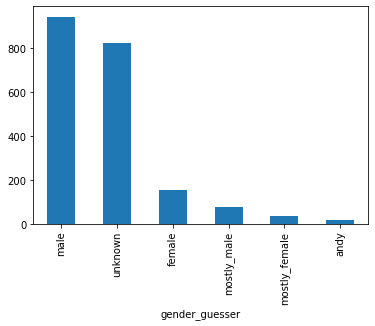

In [44]:
# Anzahl von Gender-Erwähnungen in Artikeln pro Author Gender
df_ner_full[df_ner_full.author_gender == 'male'].groupby(['gender_guesser'])["gender_guesser"].count().sort_values(ascending=False).plot(kind="bar")

<AxesSubplot:xlabel='gender_guesser'>

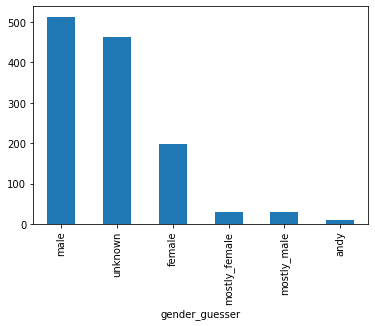

In [45]:
# Anzahl von Gender-Erwähnungen in Artikeln pro Author Gender
df_ner_full[df_ner_full.author_gender == 'female'].groupby(['gender_guesser'])["gender_guesser"].count().sort_values(ascending=False).plot(kind="bar")

In [46]:
male_guesser = pd.DataFrame(df_ner_full[df_ner_full.author_gender == 'male'].groupby(['gender_guesser'])["id"].count())
male_guesser = male_guesser.rename(columns={"id": "count_male"})
female_guesser = pd.DataFrame(df_ner_full[df_ner_full.author_gender == 'female'].groupby(['gender_guesser'])["id"].count())
female_guesser = female_guesser.rename(columns={"id": "count_female"})
total_guesser = pd.concat([male_guesser,female_guesser], axis = 1, sort = False)
total_guesser

,count_male,count_female
gender_guesser,,
andy,17,9
female,153,199
male,944,513
mostly_female,35,29
mostly_male,76,29
unknown,826,464


In [47]:
total_guesser = total_guesser.drop(other)
total_guesser

,count_male,count_female
gender_guesser,,
female,153,199
male,944,513


In [48]:
total_guesser["total_male"] = df_ner_full[df_ner_full.author_gender == 'male']["id"].count()
total_guesser["relative_male"] = total_guesser["count_male"] / total_guesser["total_male"] * 100
total_guesser["total_female"] = df_ner_full[df_ner_full.author_gender == 'female']["id"].count()
total_guesser["relative_female"] = total_guesser["count_female"] / total_guesser["total_female"] * 100
total_guesser

,count_male,count_female,total_male,relative_male,total_female,relative_female
gender_guesser,,,,,,
female,153,199,2051,7.459776,1243,16.009654
male,944,513,2051,46.026329,1243,41.271118


Text(0, 0.5, 'Anzahl')

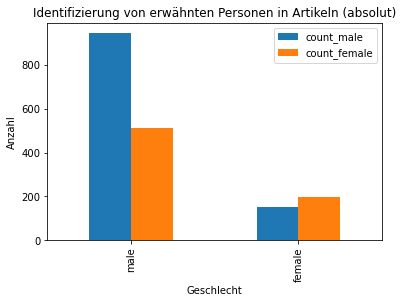

In [49]:
total_guesser[["count_male", "count_female"]].sort_values(by='count_male', ascending=False).plot(kind="bar")
plt.title('Identifizierung von erwähnten Personen in Artikeln (absolut)')
plt.xlabel('Geschlecht')
plt.ylabel('Anzahl')

Text(0.5, 1.0, 'Identifizierung von erwähnten Personen in Artikeln (relative)')

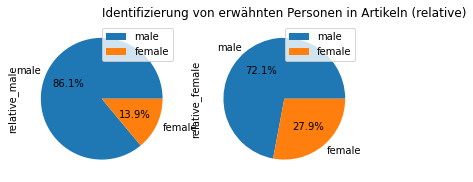

In [50]:
total_guesser[["relative_male", "relative_female"]].sort_values(by='relative_male', ascending=False).plot(kind="pie", subplots=True, autopct='%1.1f%%')
plt.title('Identifizierung von erwähnten Personen in Artikeln (relative)')

In [51]:
# Gründe für Unkown aufzeigen
# Was ist wenn mehrere Persons in Artikel? Frage an Julia
# Gender None , warum?

---
---
---
---
---
---

# | UNFERTIGE FUNKTIONEN

In [ ]:
# id
# article_url
# title
# author
# published_date
# type
# source
# content
# publish_date
# orig-id
# text
# merged_total_text
# entitys

# df[df['publish_date'].isnull()]

In [81]:
# NER 'PERSON' STARTS HERE
#df = (df.loc[df['entity_type'].isin(['PERSON'])])

In [ ]:
#df["entity"] = df['entity'].str.replace('[\[\]\"\'\d\,\<\/]','')

In [ ]:
# Replace artist names (Sting, Bono, Cher etc.) with name according to wikipedia
def replaceEntityNames(x):
    try:
        entitys = x.entitys
        artists = {
            'JFK': 'John Fitzgerald Kennedy',
            'FDR': 'Franklin Delano Roosevelt',
            'Sting': 'Gordon Matthew Sumner',
            'Bono': 'Paul David Hewson',
            'Cher': 'Cherilyn Sarkisian',
            'Madonna': 'Madonna Louise Ciccone',
            'Adele': 'Adele Laurie Adkins',
            'Eminem': 'Marshall Bruce Mathers',
            'Beyonce': 'Beyoncé Knowles-Carter',
            'Blaine Friedlander': 'Blaine P. Friedlander Jr.'
        }

        for entityKey, entityValue in entitys.items():
            if entityValue == 'PERSON':
                for artAbkzg, artName in artists.items():
                    if entityKey == artAbkzg:
                        entitys[artName]=entityValue
                        del entitys[entityKey]  
    
        return entitys
    except:
        return x.entitys
# !!! NOCH FEHLERHAFT
#df['entitys'] = df.parallel_apply(replaceEntityNames, axis=1)

In [ ]:
df = df[df['author'] != df['entity']] # if author is in col entity -> remove, we only want "Person" from within the article
# To do: Blaine P. Friedlander Jr. vs. Blaine Friedlander 

## Split first, middle and last name in different cols

In [ ]:
# Write first, middle and last name in different cols
# to do: split middle and last name does not work
def split_name(df, var):
    sub_df = df[var].str.split('\\s+', expand=True)
    result = []

    for _, row in sub_df.iterrows():
        info = {'first_name': '', 'middle_name': '', 'last_name': ''}
        n = row.count()

        if n == 0:
            pass
        elif n == 1:
            info['last_name'] = row.iloc[0]
        elif n == 2:
            info['first_name'], info['last_name'] = row.iloc[:2]
        else:
            info['first_name'] = row.iloc[0]
            info['last_name'] = row.iloc[-1]
            info['middle_name'] = ' '.join([(string or '') for string in row.iloc[1:-1]])
        result.append(info)
    return pd.DataFrame(result, index=df.index)

df_names = split_name(df, 'entitys')
df = df.join(df_names)

## | Enrich first name if only last name is mentioned

In [ ]:
names = df.groupby('id')['entity'].apply(lambda x: list(np.unique(x)))
# To do: if only one token ("Obama") drop or don't write to list

In [ ]:
# function for enriching first name if only last name is mentioned
from tqdm import tqdm
tqdm.pandas()
def enrich_firstname(row):
    
    entity = row['entity']#.copy()
    firstname = row['first_name']#.copy()
    lastname = row['last_name']#.copy()
    
    #if len(firstname) == 0:
        # look in list per id for key and write value?
    # elif 
    # bestehende Vornamen nicht überschreiben
    #else:
    #    row['first_name'] = 'unknown'
    return row

df_test = df_test.progress_apply(enrich_firstname, axis=1)


# | Gender Guesser

In [ ]:
# !pip install gender_guesser    
import gender_guesser.detector as gender
gd = gender.Detector()
df['gender_guesser'] = df['first_name'].apply(str.capitalize).map(lambda x: gd.get_gender(x))

> __unknown__ (name not found), __andy__ (androgynous), __male__, __female__, __mostly_male__, or __mostly_female__. The difference between andy and unknown is that the former is found to have the same probability to be male than to be female, while the later means that the name wasn’t found in the database.

In [ ]:
df.gender_guesser.value_counts()

In [ ]:
df.loc[df['gender_guesser'] == 'unknown'][:40]

In [ ]:
# df.first_name.value_counts()[:40]

In [ ]:
# to do:
# Namen cleanen
# weitere lib für gender identification einbauen
# function schreiben: wenn nur Nachname genannt, schaue in Liste/anderer Zeile pro Artikel, ob Name schon genannt, dann Vorname auffüllen
# oder
# wenn Obama, Santorum, Gingrich, etc. dann aus erstellter Liste oder via Wikidata mit Vornamen auffüllen
# # dominique rodgers cromartie etc. (famous people)  -> Wikidata? 

---
# | Group per article and get share of gender per article

In [ ]:
# next

# | Wikidata Query

In [ ]:
# oder das https://stackoverflow.com/questions/51419785/extract-data-from-wikidata-in-python

import requests

sparql_query = """
        prefix schema: <http://schema.org/>
        SELECT ?item ?occupation ?genderLabel ?bdayLabel
        WHERE {
            <https://en.wikipedia.org/wiki/Angela_Merkel> schema:about ?item .
            ?item wdt:P21 ?gender .
            SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }
        }
    """

In [ ]:
url = 'https://query.wikidata.org/sparql'

# sleep(2)
r = requests.get(url, params={'format': 'json', 'query': sparql_query})

In [ ]:
url = 'https://query.wikidata.org/sparql'

r = requests.get(url, params={'format': 'json', 'query': sparql_query})
data = r.json()

print(data['results']['bindings'])